In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
import sys
sys.path.append('../code')
from gplar import GPLARegressor

In [2]:
N = 256
x = np.linspace(0.0,1.0,N).reshape(N,1)

f1 = lambda x: -np.sin(10*np.pi*(x+1))/(2*x+1)-x**4
h1 = lambda x: f1(x) + np.random.normal(0,1e-5)
y1 = np.array(list(map(h1,x))) + np.random.normal(0,0.05,N).reshape(N,1)

f2 = lambda x: np.cos(h1(x))**2 + np.sin(3*x)
h2 = lambda x: f2(x) + np.random.normal(0,1e-5)
y2 = np.array(list(map(h2,x))) + np.random.normal(0,0.05,N).reshape(N,1)

f3 = lambda x: h2(x)*h1(x)**2 + 3*x
h3 = lambda x: f3(x) + np.random.normal(0,1e-5)
y3 = np.array(list(map(h3,x))) + np.random.normal(0,0.05,N).reshape(N,1)

In [3]:
mask_2_continuous = np.array([False]*156 + [True]*100)
mask_3_continuous = np.array([False]*156 + [True]*100)

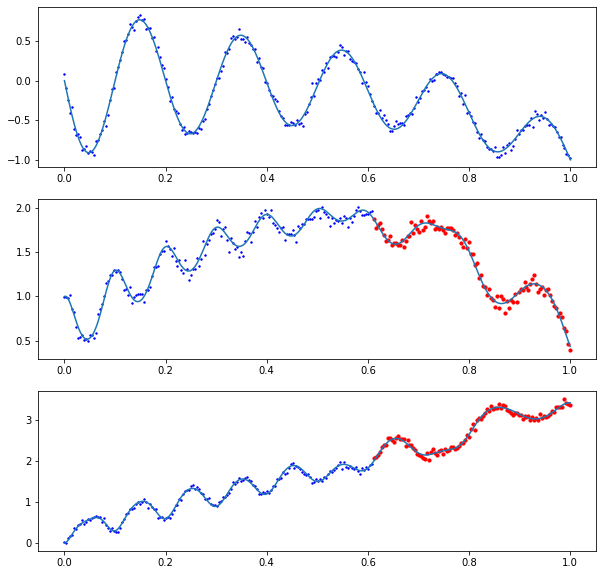

In [4]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))

ax1.scatter(x,y1,s=2,c='blue')
#ax1.scatter(x[~mask_1_continuous],y1[~mask_1_continuous], s=2, c='blue')
#ax1.scatter(x[mask_1_continuous],y1[mask_1_continuous], s=10, c='red')
x_ = np.linspace(0.0,1.0,1000)
h1_ = np.array(list(map(f1,x_)))
ax1.plot(x_,h1_)

ax2.scatter(x[~mask_2_continuous],y2[~mask_2_continuous], s=2, c='blue')
ax2.scatter(x[mask_2_continuous],y2[mask_2_continuous], s=10, c='red')
f2_ = lambda x: np.cos(f1(x))**2 + np.sin(3*x)
h2_ = np.array(list(map(f2_,x_)))
ax2.plot(x_,h2_)

#ax3.scatter(x,y3, s=2, c='blue')
ax3.scatter(x[~mask_3_continuous],y3[~mask_3_continuous], s=2, c='blue')
ax3.scatter(x[mask_3_continuous],y3[mask_3_continuous], s=10, c='red')
f3_ = lambda x: f2_(x)*f1(x)**2 + 3*x
h3_ = np.array(list(map(f3_,x_)))
ax3.plot(x_,h3_)

In [5]:
y2_miss_c, y3_miss_c = y2.copy(), y3.copy()
y2_miss_c[mask_2_continuous]=None
y3_miss_c[mask_3_continuous]=None
y_obs_c = np.concatenate((y1,y2_miss_c,y3_miss_c),axis=-1)

In [9]:
from gpar.regression import GPARRegressor
gpar  = GPARRegressor(scale=0.1,
                      linear=True, linear_scale=10.,
                      nonlinear=True, nonlinear_scale=0.1,
                      noise=0.05,
                      impute=True, replace=True, normalise_y=True)
M = 256

m_c = GPLARegressor(x, y_obs_c, M, gpar, white=False,
                 scale=0.1,
                 linear=True, linear_scale=10.0,
                 nonlinear=True, nonlinear_scale=0.1,
                 noise_inner=1e-5, noise_obs=0.05,
                 num_samples=1)

Training conditionals (total: 3): 1 2 3
Sampling (total: 200): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200


In [13]:
means_c, lowers_c, uppers_c = \
    gpar.predict(x, num_samples=100, credible_bounds=True, latent=True)

Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


In [21]:
@tf.function(autograph=False)
def optimization_step(optimizer, model, data):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = -model.maximum_log_likelihood_objective(*data)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective #, model.trainable_variables

def run_adam(model, data, iterations):
    logf=[]
    check = []
    adam = tf.optimizers.Adam(0.001)
    for step in range(iterations):
        neg_elbo = optimization_step(adam, model, data)
        elbo = -neg_elbo
        if step%10 == 0:
            logf.append(elbo.numpy())
            #check.append(variables[3])
        if step%500 == 0:
            print(elbo.numpy())
    return logf#, check

In [22]:
from gpflow.ci_utils import ci_niter
maxiter = ci_niter(5000)
logf = run_adam(m_c, (x,y_obs_c), maxiter)

778.0217205462654
780.3729987172239
780.2024662994835
779.6881729459571
781.265569131443
783.4527988021953
782.1358242065988
778.1219752917555
784.1416606752518
778.4820138541414


In [23]:
#x__ = np.linspace(0.0,1.0,1000).reshape(1000,1)
Hmeans_c, Hvars_c = m_c.predict_f(x, 100)
def getMeanandBound(Hmeans,Hvars):
    Hmeans, Hvars = np.stack(Hmeans), np.stack(Hvars)
    mean = tf.reduce_mean(Hmeans,axis=1)
    sd = tf.sqrt(tf.reduce_mean(Hvars,axis=1))
        
    return mean, mean-1.96*sd, mean+1.96*sd
predict_y_c = getMeanandBound(Hmeans_c, Hvars_c)

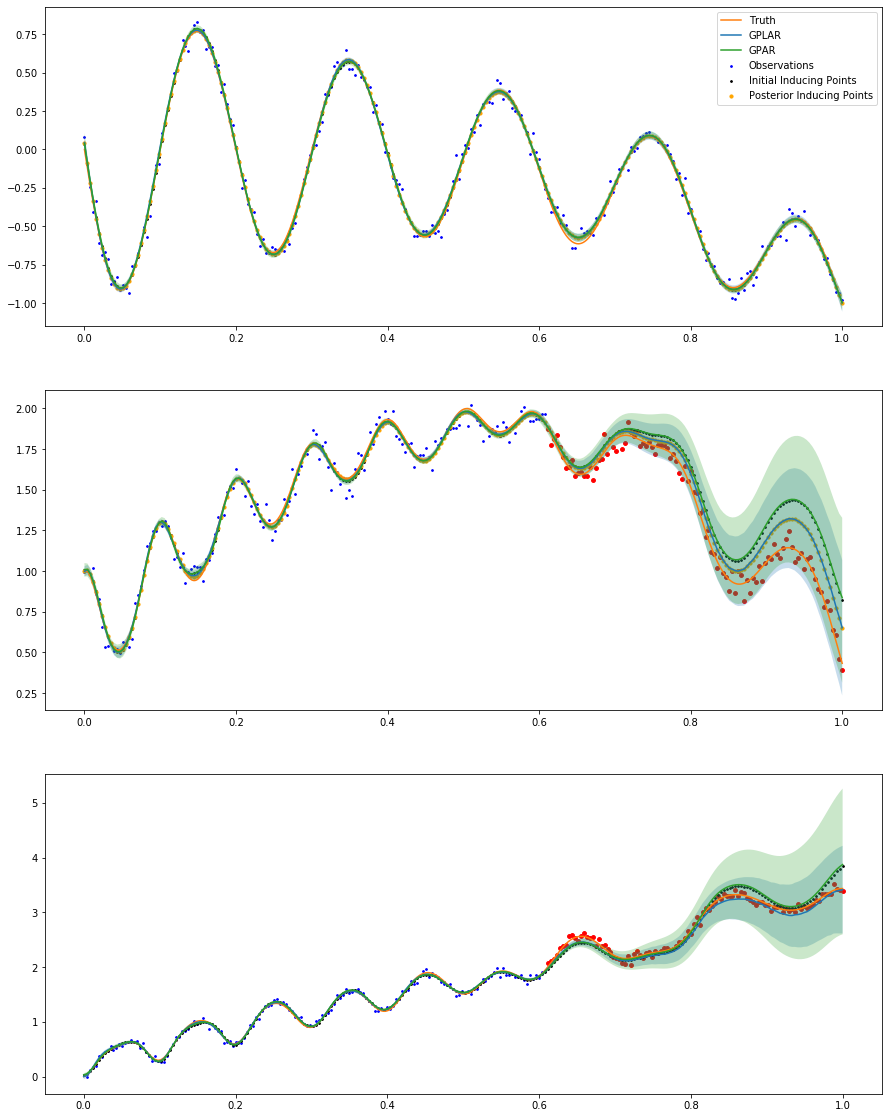

In [24]:
x__ = x
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,20))

ax1.scatter(x,y1,s=3,label='Observations',c='blue')
#ax1.scatter(x[~mask_1_continuous],y1[~mask_1_continuous], s=3, label='Observations',c='blue')
#ax1.scatter(x[mask_1_continuous],y1[mask_1_continuous],label='Missing', s=20, c='red')
ax1.scatter(m_c.initial_inducing_points[0][:,0],
            m_c.initial_inducing_points[0][:,1],
            label='Initial Inducing Points', s=3, c='black')
ax1.scatter(m_c.initial_inducing_points[0][:,0],
            m_c.layers[0].q_mu.value(),
            label='Posterior Inducing Points', s=10, c='orange')
ax1.plot(x_,h1_,label='Truth',c='tab:orange')
ax1.plot(x__,predict_y_c[0][0], label='GPLAR', c='tab:blue')
ax1.fill_between(x__[:,0],predict_y_c[1][0,:,0], predict_y_c[2][0,:,0],
                facecolor='tab:blue', alpha=.25)
ax1.plot(x__,means_c[:,0], label='GPAR', c='tab:green')
ax1.fill_between(x__[:,0],lowers_c[:,0], uppers_c[:,0],
                facecolor='tab:green', alpha=.25)
ax1.legend()

ax2.scatter(x[~mask_2_continuous],y2[~mask_2_continuous], s=3, c='blue')
ax2.scatter(x[mask_2_continuous],y2[mask_2_continuous], s=15, c='red')
ax2.scatter(m_c.initial_inducing_points[1][:,0],
            m_c.initial_inducing_points[1][:,2],
            label='Initial Inducing Points', s=3, c='black')
ax2.scatter(m_c.initial_inducing_points[1][:,0],
            m_c.layers[1].q_mu.value(),
            label='Posterior Inducing Points', s=10, c='orange')
ax2.plot(x_,h2_,label='Truth',c='tab:orange')
ax2.plot(x__,predict_y_c[0][1], label='GPLAR', c='tab:blue')
ax2.fill_between(x__[:,0],predict_y_c[1][1,:,0], predict_y_c[2][1,:,0],
                facecolor='tab:blue', alpha=.25)
ax2.plot(x__,means_c[:,1], label='GPAR', c='tab:green')
ax2.fill_between(x__[:,0],lowers_c[:,1], uppers_c[:,1],
                facecolor='tab:green', alpha=.25)

#ax3.scatter(x,y3,s=3,label='Observations',c='blue')
ax3.scatter(x[~mask_3_continuous],y3[~mask_2_continuous], s=3, c='blue')
ax3.scatter(x[mask_3_continuous],y3[mask_2_continuous], s=15, c='red')
ax3.scatter(m_c.initial_inducing_points[2][:,0],
            m_c.initial_inducing_points[2][:,3],
            label='Initial Inducing Points', s=3, c='black')
ax3.plot(x_,h3_,label='Truth',c='tab:orange')
ax3.plot(x__,predict_y_c[0][2], label='GPLAR', c='tab:blue')
ax3.fill_between(x__[:,0],predict_y_c[1][2,:,0], predict_y_c[2][2,:,0],
                facecolor='tab:blue', alpha=.25)
ax3.plot(x__,means_c[:,2], label='GPAR', c='tab:green')
ax3.fill_between(x__[:,0],lowers_c[:,2], uppers_c[:,2],
                facecolor='tab:green', alpha=.25)
f.savefig('missing_longer_only.png', dpi=300)

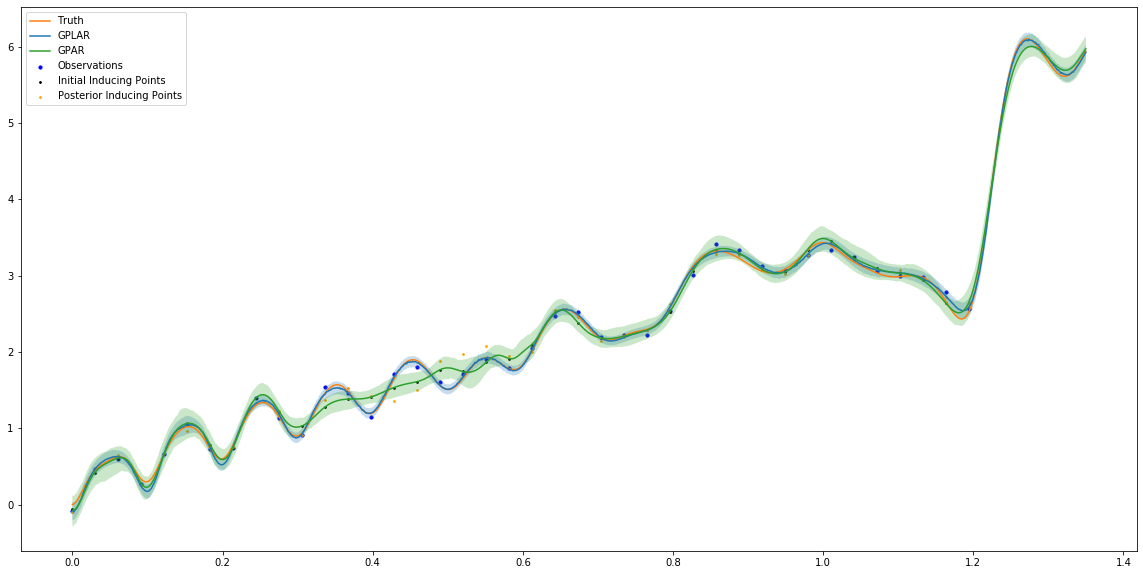

In [151]:
f = plt.figure(figsize=(20,10))
plt.scatter(x[:40,:],y3[:40,:],s=10,label='Observations',c='blue')
plt.scatter(m_c.initial_inducing_points[2][:,0][:40],
            m_c.initial_inducing_points[2][:,3][:40],
            label='Initial Inducing Points', s=3, c='black')
plt.scatter(m_c.initial_inducing_points[2][:,0][:40],
            m_c.layers[2].q_mu.value()[:40],
            label='Posterior Inducing Points', s=3, c='orange')
plt.plot(x_[:1350],h3_[:1350],label='Truth',c='tab:orange')
plt.plot(x__[:1350,:],predict_y_c[0][2,:1350,:], label='GPLAR', c='tab:blue')
plt.fill_between(x__[:1350,0],predict_y_c[1][2,:1350,0], predict_y_c[2][2,:1350,0],
                facecolor='tab:blue', alpha=.25)
plt.plot(x__[:1350,:],means_c[:1350,2], label='GPAR', c='tab:green')
plt.fill_between(x__[:1350,0],lowers_c[:1350,2], uppers_c[:1350,2],
                facecolor='tab:green', alpha=.25)
plt.legend()
plt.show()
f.savefig('close-up-thrid-output.png', dpi=300)

In [2]:
N = 50
x = np.linspace(0.0,1.0,N).reshape(N,1)

f1 = lambda x: -np.sin(10*np.pi*(x+1))/(2*x+1)-x**4
h1 = lambda x: f1(x) + np.random.normal(0,1e-5)
y1 = np.array(list(map(h1,x))) + np.random.normal(0,0.05,N).reshape(N,1)

f2 = lambda x: np.cos(h1(x))**2 + np.sin(3*x)
h2 = lambda x: f2(x) + np.random.normal(0,1e-5)
y2 = np.array(list(map(h2,x))) + np.random.normal(0,0.05,N).reshape(N,1)

f3 = lambda x: h2(x)*h1(x)**2 + 3*x
h3 = lambda x: f3(x) + np.random.normal(0,1e-5)
y3 = np.array(list(map(h3,x))) + np.random.normal(0,0.05,N).reshape(N,1)

In [3]:
# Randomly remove some first/second output
mask_1 = np.array([False]*N)
mask_1[np.random.choice(N, 10)] = True
mask_2 = np.array([False]*N)
mask_2[np.random.choice(N, 10)] = True

In [4]:
mask_1_continuous = np.array([False]*10 + [True]*10 + [False]*30)
mask_2_continuous = np.array([False]*30 + [True]*10 + [False]*10)

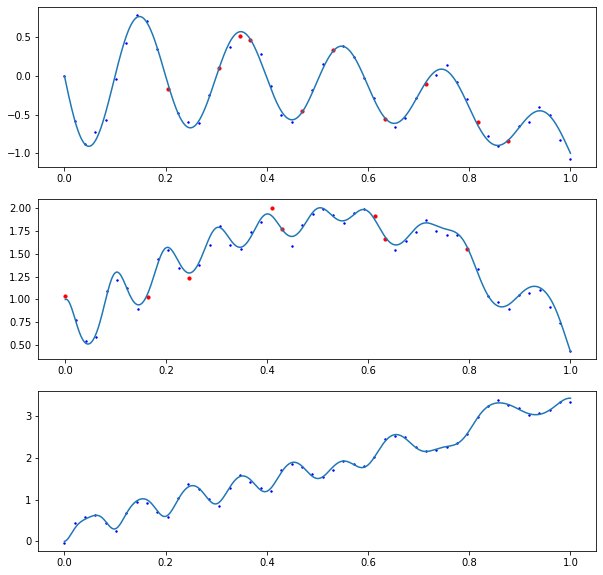

In [118]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))

ax1.scatter(x[~mask_1],y1[~mask_1], s=2, c='blue')
ax1.scatter(x[mask_1],y1[mask_1], s=10, c='red')
x_ = np.linspace(0.0,1.0,1000)
h1_ = np.array(list(map(f1,x_)))
ax1.plot(x_,h1_)

ax2.scatter(x[~mask_2],y2[~mask_2], s=2, c='blue')
ax2.scatter(x[mask_2],y2[mask_2], s=10, c='red')
f2_ = lambda x: np.cos(f1(x))**2 + np.sin(3*x)
h2_ = np.array(list(map(f2_,x_)))
ax2.plot(x_,h2_)

ax3.scatter(x,y3, s=2, c='blue')
f3_ = lambda x: f2_(x)*f1(x)**2 + 3*x
h3_ = np.array(list(map(f3_,x_)))
ax3.plot(x_,h3_)

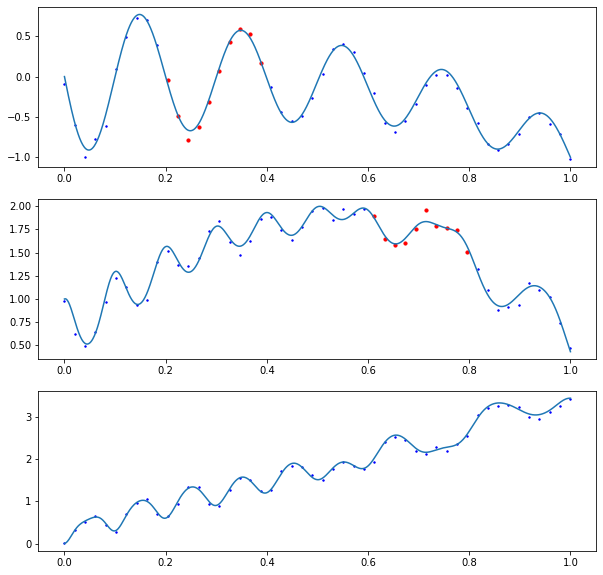

In [6]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))

ax1.scatter(x[~mask_1_continuous],y1[~mask_1_continuous], s=2, c='blue')
ax1.scatter(x[mask_1_continuous],y1[mask_1_continuous], s=10, c='red')
x_ = np.linspace(0.0,1.0,1000)
h1_ = np.array(list(map(f1,x_)))
ax1.plot(x_,h1_)

ax2.scatter(x[~mask_2_continuous],y2[~mask_2_continuous], s=2, c='blue')
ax2.scatter(x[mask_2_continuous],y2[mask_2_continuous], s=10, c='red')
f2_ = lambda x: np.cos(f1(x))**2 + np.sin(3*x)
h2_ = np.array(list(map(f2_,x_)))
ax2.plot(x_,h2_)

ax3.scatter(x,y3, s=2, c='blue')
f3_ = lambda x: f2_(x)*f1(x)**2 + 3*x
h3_ = np.array(list(map(f3_,x_)))
ax3.plot(x_,h3_)

In [74]:
y1_miss, y2_miss = y1.copy(), y2.copy()
y1_miss[mask_1]=None
y2_miss[mask_2]=None
y_obs = np.concatenate((y1_miss,y2_miss,y3),axis=-1)

In [75]:
M = 50-20 # number of inducing points
m = GPLARegressor(x, y_obs, M, white=False,
                 scale=0.1,
                 linear=True, linear_scale=10.0,
                 nonlinear=True, nonlinear_scale=0.1,
                 noise_inner=1e-5, noise_obs=0.05,
                 num_samples=100)

-1953.6575542801272
-69.64602273506031
-18.82524410379297
8.894854828381966
29.701023099941054
43.391480944772354
55.66707054001637
67.0248029662045
76.8513563201692
85.33116643447723
89.74331775762637
94.12557327224712
96.55612095894399
98.85883036324206
97.96378610166194


Text(0.5, 1.0, 'ELBO of GPLAR')

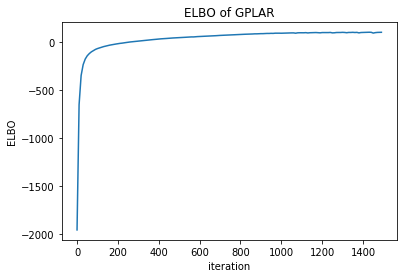

In [77]:
from gpflow.ci_utils import ci_niter
maxiter = ci_niter(1500)
logf = run_adam(m, (x,y_obs), maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');
plt.title('ELBO of GPLAR')

-2758.243986910529
-137.2885081514304
-67.4838164890516
-44.210942266052044
-29.58470635947279
-22.00382265966192
-15.240921239183422
2.7332914834967
3.968403646802585
11.98713661781386
22.79959161461052
0.2934101433871632
35.99799221908812
35.93687762646118
38.27658580428421
48.016083905934025
41.510633460233024
42.741356564578766
53.37521292691767
51.574498650210884


Text(0.5, 1.0, 'ELBO of GPLAR continuous missing')

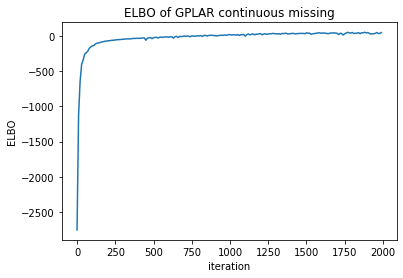

In [14]:
from gpflow.ci_utils import ci_niter
maxiter = ci_niter(2000)
logf = run_adam(m_c, (x,y_obs_c), maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel('iteration')
plt.ylabel('ELBO');
plt.title('ELBO of GPLAR continuous missing')

In [12]:
gpflow.utilities.print_summary(m_c, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
GPLARegressor.likelihoods[0].variance GPLARegressor.likelihoods[1].variance GPLARegressor.likelihoods[2].variance,Parameter,Softplus + Shift,,True,(),float64,0.003734012691076544
GPLARegressor.layers[0].inducing_points.Z,Parameter,,,False,"(85, 1)",float64,[[0.93939394...
GPLARegressor.layers[0].q_mu,Parameter,,,True,"(85, 1)",float64,[[-0.40714788...
GPLARegressor.layers[0].q_sqrt,Parameter,FillTriangular,,True,"(85, 85)",float64,"[[2.16119323e-02, 0.00000000e+00, 0.00000000e+00..."
GPLARegressor.layers[0].kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,4.222833100688307
GPLARegressor.layers[0].kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.10515744402682346
GPLARegressor.layers[0].kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,5.7252855248603945e-06
GPLARegressor.layers[1].inducing_points.Z,Parameter,,,False,"(70, 2)",float64,"[[1.5, -5.071196..."
GPLARegressor.layers[1].q_mu,Parameter,,,True,"(70, 1)",float64,[[-0.8350973...
GPLARegressor.layers[1].q_sqrt,Parameter,FillTriangular,,True,"(70, 70)",float64,"[[0.01300526, 0., 0...."


In [120]:
x__ = np.linspace(0.0,1.0,1000).reshape(1000,1)

In [86]:
Hmeans_c, Hvars_c = m_c.predict_f(x__, 100)

In [79]:
Hmeans, Hvars = m.predict_f(x__, 100)

In [87]:
def getMeanandBound(Hmeans,Hvars):
    Hmeans, Hvars = np.stack(Hmeans), np.stack(Hvars)
    mean = tf.reduce_mean(Hmeans,axis=1)
    sd = tf.sqrt(tf.reduce_mean(Hvars,axis=1))
        
    return mean, mean-1.96*sd, mean+1.96*sd  #2.5~97.5 percentile same as used in GPAR

In [88]:
predict_y_c = getMeanandBound(Hmeans_c, Hvars_c)

In [80]:
predict_y = getMeanandBound(Hmeans, Hvars)

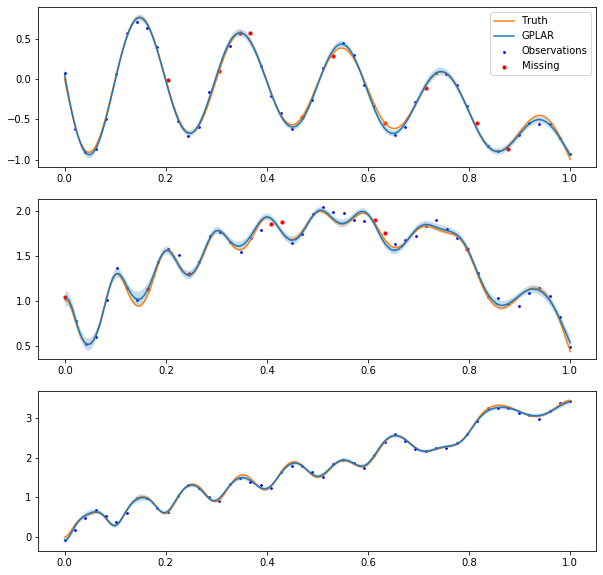

In [81]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))

ax1.scatter(x[~mask_1],y1[~mask_1], s=3, label='Observations',c='blue')
ax1.scatter(x[mask_1],y1[mask_1],label='Missing', s=10, c='red')
ax1.plot(x_,h1_,label='Truth',c='tab:orange')
ax1.plot(x__,predict_y[0][0], label='GPLAR', c='tab:blue')
ax1.fill_between(x__[:,0],predict_y[1][0,:,0], predict_y[2][0,:,0],
                facecolor='tab:blue', alpha=.25)
ax1.legend()

ax2.scatter(x[~mask_2],y2[~mask_2], s=3, c='blue')
ax2.scatter(x[mask_2],y2[mask_2], s=10, c='red')
ax2.plot(x_,h2_,label='Truth',c='tab:orange')
ax2.plot(x__,predict_y[0][1], label='GPLAR', c='tab:blue')
ax2.fill_between(x__[:,0],predict_y[1][1,:,0], predict_y[2][1,:,0],
                facecolor='tab:blue', alpha=.25)

ax3.scatter(x,y_obs[:,2:],s=3,label='Observations',c='blue')
ax3.plot(x_,h3_,label='Truth',c='tab:orange')
ax3.plot(x__,predict_y[0][2], label='GPLAR', c='tab:blue')
ax3.fill_between(x__[:,0],predict_y[1][2,:,0], predict_y[2][2,:,0],
                facecolor='tab:blue', alpha=.25)


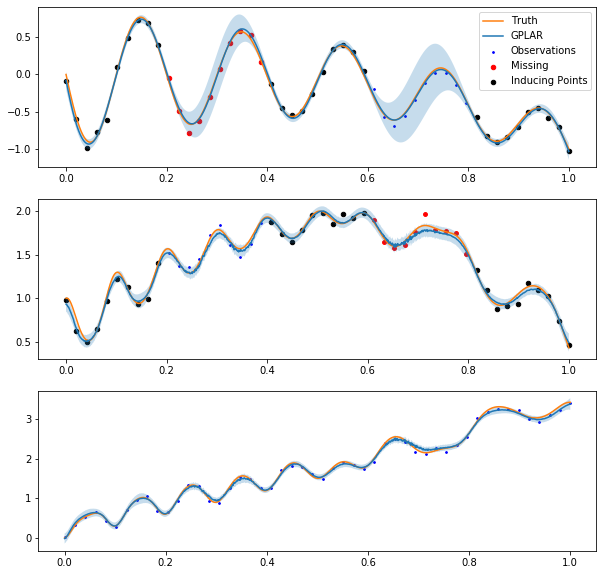

In [22]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))

ax1.scatter(x[~mask_1_continuous],y1[~mask_1_continuous], s=3, label='Observations',c='blue')
ax1.scatter(x[mask_1_continuous],y1[mask_1_continuous],label='Missing', s=20, c='red')
ax1.scatter(m_c.layers[1].inducing_points.Z[:,0],
            m_c.layers[1].inducing_points.Z[:,1],
            label='Inducing Points', s=20, c='black')
ax1.plot(x_,h1_,label='Truth',c='tab:orange')
ax1.plot(x__,predict_y_c[0][0], label='GPLAR', c='tab:blue')
ax1.fill_between(x__[:,0],predict_y_c[1][0,:,0], predict_y_c[2][0,:,0],
                facecolor='tab:blue', alpha=.25)
ax1.legend()

ax2.scatter(x[~mask_2_continuous],y2[~mask_2_continuous], s=3, c='blue')
ax2.scatter(x[mask_2_continuous],y2[mask_2_continuous], s=15, c='red')
ax2.scatter(m_c.layers[2].inducing_points.Z[:,0],
            m_c.layers[2].inducing_points.Z[:,2],
            label='Inducing Points', s=20, c='black')
ax2.plot(x_,h2_,label='Truth',c='tab:orange')
ax2.plot(x__,predict_y_c[0][1], label='GPLAR', c='tab:blue')
ax2.fill_between(x__[:,0],predict_y_c[1][1,:,0], predict_y_c[2][1,:,0],
                facecolor='tab:blue', alpha=.25)

ax3.scatter(x,y3,s=3,label='Observations',c='blue')
ax3.plot(x_,h3_,label='Truth',c='tab:orange')
ax3.plot(x__,predict_y_c[0][2], label='GPLAR', c='tab:blue')
ax3.fill_between(x__[:,0],predict_y_c[1][2,:,0], predict_y_c[2][2,:,0],
                facecolor='tab:blue', alpha=.25)

In [118]:
from gpar.regression import GPARRegressor

In [24]:
from gpar.regression import GPARRegressor
model = GPARRegressor(scale=0.1,
                      linear=True, linear_scale=10.,
                      nonlinear=True, nonlinear_scale=0.1,
                      noise=0.1,
                      impute=True, replace=True, normalise_y=False)
model.fit(x,y_obs)

Training conditionals (total: 3): 1 2 3


In [40]:
model_c = GPARRegressor(scale=0.1,
                      linear=True, linear_scale=10.,
                      nonlinear=True, nonlinear_scale=0.1,
                      noise=0.1,
                      impute=True, replace=True, normalise_y=False)
model_c.fit(x[:,0],y_obs_c)

Training conditionals (total: 3): 1 2 3


In [119]:
model_c = GPARRegressor(scale=0.1,
                      linear=True, linear_scale=10.,
                      nonlinear=True, nonlinear_scale=0.1,
                      noise=0.05,
                      impute=True, replace=True, normalise_y=True)
model_c.fit(x,y_obs_c)

Training conditionals (total: 3): 1 2 3


In [81]:
means_c, lowers_c, uppers_c = \
    model_c.predict(x__, num_samples=200, credible_bounds=True, latent=True)

Sampling (total: 200): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200


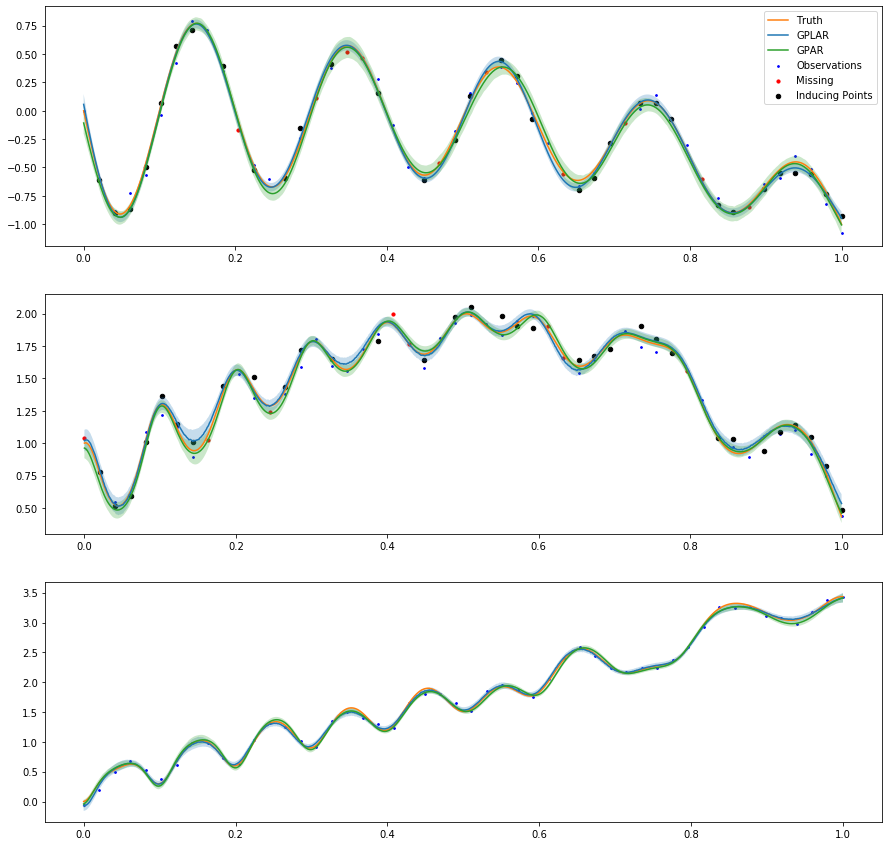

In [121]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15))

ax1.scatter(x[~mask_1],y1[~mask_1], s=3, label='Observations',c='blue')
ax1.scatter(x[mask_1],y1[mask_1],label='Missing', s=10, c='red')
ax1.scatter(m.layers[1].inducing_points.Z[:,0],
            m.layers[1].inducing_points.Z[:,1],
            label='Inducing Points', s=20, c='black')
ax1.plot(x_,h1_,label='Truth',c='tab:orange')
ax1.plot(x__,predict_y[0][0], label='GPLAR', c='tab:blue')
ax1.fill_between(x__[:,0],predict_y[1][0,:,0], predict_y[2][0,:,0],
                facecolor='tab:blue', alpha=.25)
ax1.plot(x__,means[:,0], label='GPAR', c='tab:green')
ax1.fill_between(x__[:,0],lowers[:,0], uppers[:,0],
                facecolor='tab:green', alpha=.25)
ax1.legend()

ax2.scatter(x[~mask_2],y2[~mask_2], s=3, c='blue')
ax2.scatter(x[mask_2],y2[mask_2], s=10, c='red')
ax2.scatter(m.layers[2].inducing_points.Z[:,0],
            m.layers[2].inducing_points.Z[:,2],
            label='Inducing Points', s=20, c='black')
ax2.plot(x_,h2_,label='Truth',c='tab:orange')
ax2.plot(x__,predict_y[0][1], label='GPLAR', c='tab:blue')
ax2.fill_between(x__[:,0],predict_y[1][1,:,0], predict_y[2][1,:,0],
                facecolor='tab:blue', alpha=.25)
ax2.plot(x__,means[:,1], label='GPAR', c='tab:green')
ax2.fill_between(x__[:,0],lowers[:,1], uppers[:,1],
                facecolor='tab:green', alpha=.25)

ax3.scatter(x,y_obs[:,2:],s=3,label='Observations',c='blue')
ax3.plot(x_,h3_,label='Truth',c='tab:orange')
ax3.plot(x__,predict_y[0][2], label='GPLAR', c='tab:blue')
ax3.fill_between(x__[:,0],predict_y[1][2,:,0], predict_y[2][2,:,0],
                facecolor='tab:blue', alpha=.25)
ax3.plot(x__,means[:,2], label='GPAR', c='tab:green')
ax3.fill_between(x__[:,0],lowers[:,2], uppers[:,2],
                facecolor='tab:green', alpha=.25)
f.savefig('missing_all_pseudo.png',dpi=300)

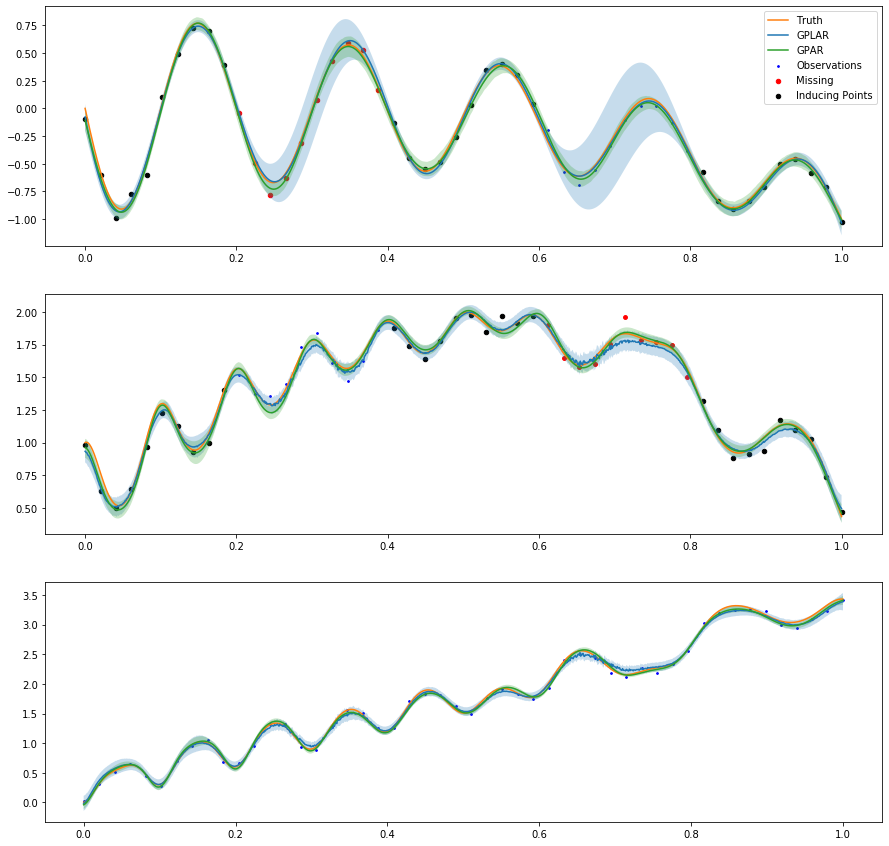

In [41]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15))

ax1.scatter(x[~mask_1_continuous],y1[~mask_1_continuous], s=3, label='Observations',c='blue')
ax1.scatter(x[mask_1_continuous],y1[mask_1_continuous],label='Missing', s=20, c='red')
ax1.scatter(m_c.layers[1].inducing_points.Z[:,0],
            m_c.layers[1].inducing_points.Z[:,1],
            label='Inducing Points', s=20, c='black')
ax1.plot(x_,h1_,label='Truth',c='tab:orange')
ax1.plot(x__,predict_y_c[0][0], label='GPLAR', c='tab:blue')
ax1.fill_between(x__[:,0],predict_y_c[1][0,:,0], predict_y_c[2][0,:,0],
                facecolor='tab:blue', alpha=.25)
ax1.plot(x__,means[:,0], label='GPAR', c='tab:green')
ax1.fill_between(x__[:,0],lowers[:,0], uppers[:,0],
                facecolor='tab:green', alpha=.25)
ax1.legend()

ax2.scatter(x[~mask_2_continuous],y2[~mask_2_continuous], s=3, c='blue')
ax2.scatter(x[mask_2_continuous],y2[mask_2_continuous], s=15, c='red')
ax2.scatter(m_c.layers[2].inducing_points.Z[:,0],
            m_c.layers[2].inducing_points.Z[:,2],
            label='Inducing Points', s=20, c='black')
ax2.plot(x_,h2_,label='Truth',c='tab:orange')
ax2.plot(x__,predict_y_c[0][1], label='GPLAR', c='tab:blue')
ax2.fill_between(x__[:,0],predict_y_c[1][1,:,0], predict_y_c[2][1,:,0],
                facecolor='tab:blue', alpha=.25)
ax2.plot(x__,means[:,1], label='GPAR', c='tab:green')
ax2.fill_between(x__[:,0],lowers[:,1], uppers[:,1],
                facecolor='tab:green', alpha=.25)

ax3.scatter(x,y3,s=3,label='Observations',c='blue')
ax3.plot(x_,h3_,label='Truth',c='tab:orange')
ax3.plot(x__,predict_y_c[0][2], label='GPLAR', c='tab:blue')
ax3.fill_between(x__[:,0],predict_y_c[1][2,:,0], predict_y_c[2][2,:,0],
                facecolor='tab:blue', alpha=.25)
ax3.plot(x__,means[:,2], label='GPAR', c='tab:green')
ax3.fill_between(x__[:,0],lowers[:,2], uppers[:,2],
                facecolor='tab:green', alpha=.25)
f.savefig('missing_c_all_pseudo.png',dpi=300)


In [36]:
print('GPLAR:')
print('sum of square y1:',(tf.reduce_sum((h1_[:,None]-predict_y_c[0][0])**2).numpy()))
print('sum of square y2:',(tf.reduce_sum((h2_[:,None]-predict_y_c[0][1])**2).numpy()))
print('sum of square y3:',(tf.reduce_sum((h3_[:,None]-predict_y_c[0][2])**2).numpy()))

GPLAR:
sum of square y1: 0.8276346951922249
sum of square y2: 1.1135054047925461
sum of square y3: 1.8207313090800339


In [37]:
print('GPAR')
print('sum of square y1:',np.sum((h1_-means_c[:,0])**2))
print('sum of square y2:',np.sum((h2_-means_c[:,1])**2))
print('sum of square y3:',np.sum((h3_-means_c[:,2])**2))

GPAR
sum of square y1: 10.405160012676205
sum of square y2: 2.894407619481861
sum of square y3: 3.116166051237764


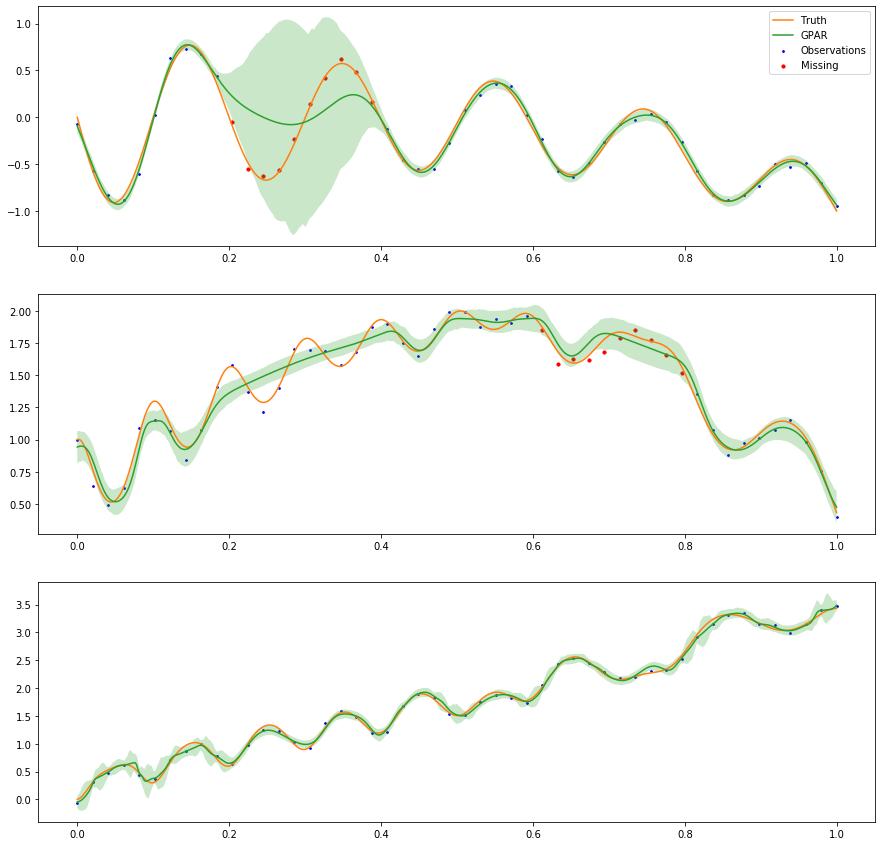

In [46]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15))

ax1.scatter(x[~mask_1_continuous],y1[~mask_1_continuous], s=3, label='Observations',c='blue')
ax1.scatter(x[mask_1_continuous],y1[mask_1_continuous],label='Missing', s=10, c='red')
ax1.plot(x_,h1_,label='Truth',c='tab:orange')
ax1.plot(x__,means_c[:,0], label='GPAR', c='tab:green')
ax1.fill_between(x__[:,0],lowers_c[:,0], uppers_c[:,0],
                facecolor='tab:green', alpha=.25)
ax1.legend()

ax2.scatter(x[~mask_2_continuous],y2[~mask_2_continuous], s=3, c='blue')
ax2.scatter(x[mask_2_continuous],y2[mask_2_continuous], s=10, c='red')
ax2.plot(x_,h2_,label='Truth',c='tab:orange')
ax2.plot(x__,means_c[:,1], label='GPAR', c='tab:green')
ax2.fill_between(x__[:,0],lowers_c[:,1], uppers_c[:,1],
                facecolor='tab:green', alpha=.25)

ax3.scatter(x,y3,s=3,label='Observations',c='blue')
ax3.plot(x_,h3_,label='Truth',c='tab:orange')
ax3.plot(x__,means_c[:,2], label='GPAR', c='tab:green')
ax3.fill_between(x__[:,0],lowers_c[:,2], uppers_c[:,2],
                facecolor='tab:green', alpha=.25)

In [94]:
print('GPLAR:')
print('sum of square y1:',(tf.reduce_sum((h1_[:,None]-predict_y_c[0][0])**2).numpy()))
print('sum of square y2:',(tf.reduce_sum((h2_[:,None]-predict_y_c[0][1])**2).numpy()))
print('sum of square y3:',(tf.reduce_sum((h3_[:,None]-predict_y_c[0][2])**2).numpy()))

GPLAR:
sum of square y1: 1.4328405770820176
sum of square y2: 0.9031066966649133
sum of square y3: 1.4359384460690277


In [95]:
print('GPAR')
print('sum of square y1:',np.sum((h1_-means_c[:,0])**2))
print('sum of square y2:',np.sum((h2_-means_c[:,1])**2))
print('sum of square y3:',np.sum((h3_-means_c[:,2])**2))

GPAR
sum of square y1: 141.46111270231032
sum of square y2: 7.140946987484284
sum of square y3: 1.749607863101247


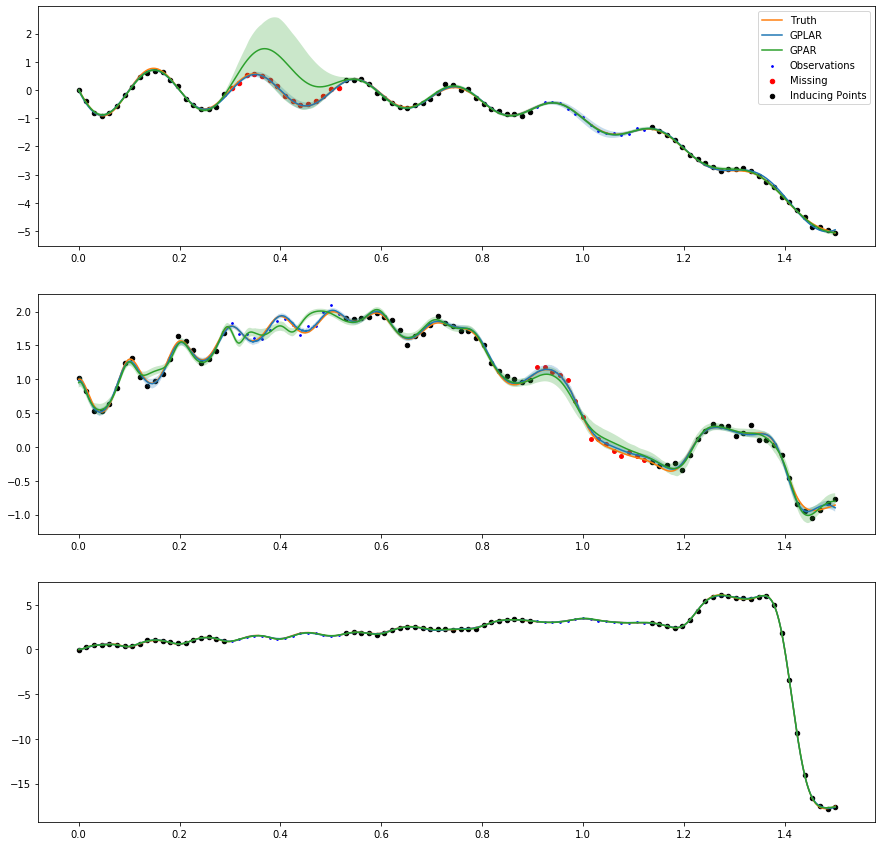

In [96]:
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15))

ax1.scatter(x[~mask_1_continuous],y1[~mask_1_continuous], s=3, label='Observations',c='blue')
ax1.scatter(x[mask_1_continuous],y1[mask_1_continuous],label='Missing', s=20, c='red')
ax1.scatter(m_c.layers[1].inducing_points.Z[:,0],
            m_c.layers[1].inducing_points.Z[:,1],
            label='Inducing Points', s=20, c='black')
ax1.plot(x_,h1_,label='Truth',c='tab:orange')
ax1.plot(x__,predict_y_c[0][0], label='GPLAR', c='tab:blue')
ax1.fill_between(x__[:,0],predict_y_c[1][0,:,0], predict_y_c[2][0,:,0],
                facecolor='tab:blue', alpha=.25)
ax1.plot(x__,means_c[:,0], label='GPAR', c='tab:green')
ax1.fill_between(x__[:,0],lowers_c[:,0], uppers_c[:,0],
                facecolor='tab:green', alpha=.25)
ax1.legend()

ax2.scatter(x[~mask_2_continuous],y2[~mask_2_continuous], s=3, c='blue')
ax2.scatter(x[mask_2_continuous],y2[mask_2_continuous], s=15, c='red')
ax2.scatter(m_c.layers[2].inducing_points.Z[:,0],
            m_c.layers[2].inducing_points.Z[:,2],
            label='Inducing Points', s=20, c='black')
ax2.plot(x_,h2_,label='Truth',c='tab:orange')
ax2.plot(x__,predict_y_c[0][1], label='GPLAR', c='tab:blue')
ax2.fill_between(x__[:,0],predict_y_c[1][1,:,0], predict_y_c[2][1,:,0],
                facecolor='tab:blue', alpha=.25)
ax2.plot(x__,means_c[:,1], label='GPAR', c='tab:green')
ax2.fill_between(x__[:,0],lowers_c[:,1], uppers_c[:,1],
                facecolor='tab:green', alpha=.25)

ax3.scatter(x,y3,s=3,label='Observations',c='blue')
ax3.scatter(x[np.logical_and(~mask_1_continuous,~mask_2_continuous)],
            y3[np.logical_and(~mask_1_continuous,~mask_2_continuous)],
            label='Inducing Locations', s=20, c='black')
ax3.plot(x_,h3_,label='Truth',c='tab:orange')
ax3.plot(x__,predict_y_c[0][2], label='GPLAR', c='tab:blue')
ax3.fill_between(x__[:,0],predict_y_c[1][2,:,0], predict_y_c[2][2,:,0],
                facecolor='tab:blue', alpha=.25)
ax3.plot(x__,means_c[:,2], label='GPAR', c='tab:green')
ax3.fill_between(x__[:,0],lowers_c[:,2], uppers_c[:,2],
                facecolor='tab:green', alpha=.25)
f.savefig('missing_c_longer.png',dpi=300)

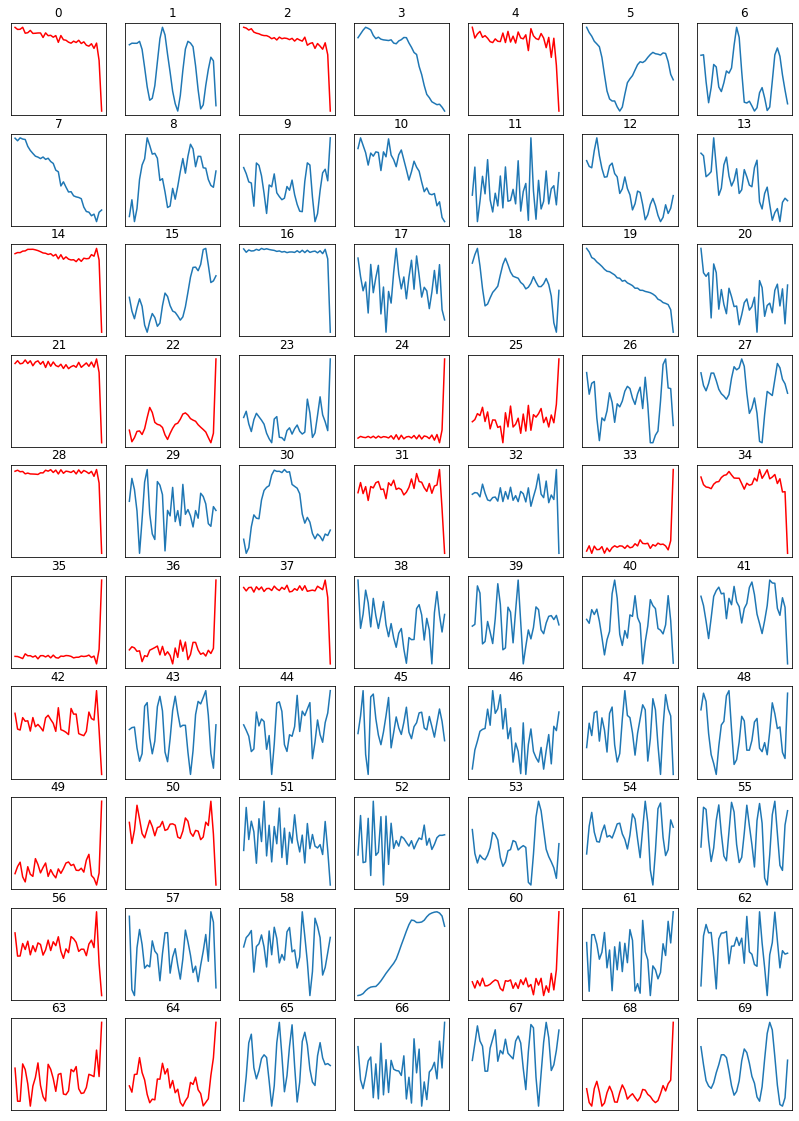

In [52]:
nrow = 10; ncol = 7;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(14,20))

for i in range(nrow):
    for j in range(ncol):
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].set_title(str(i*7+j))
        if i*7+j in (0,2,4,14,16,21,22,24,25,28,31,33,34,35,36,37,39,42,49,50,56,60,63,64,68):
            axs[i][j].plot(list(range(600,len(check))), monitor[i*7+j], 'r')
        else:
            axs[i][j].plot(list(range(600,len(check))), monitor[i*7+j])

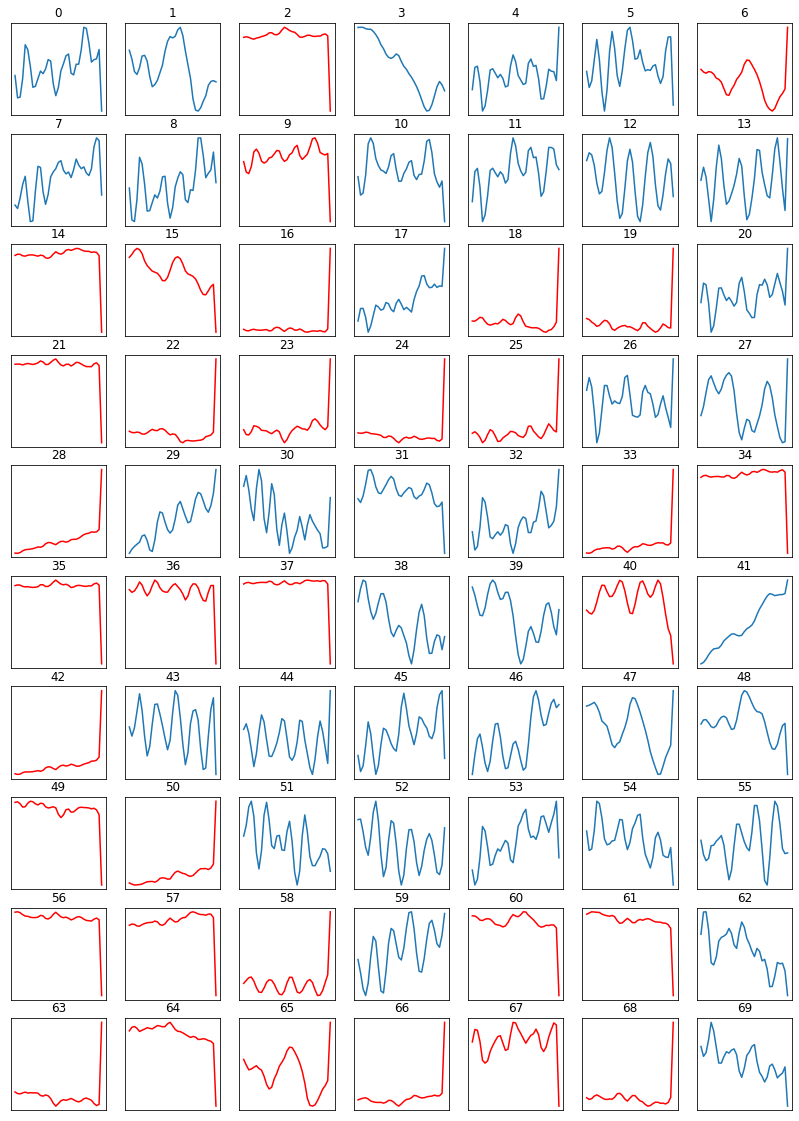

In [67]:
nrow = 10; ncol = 7;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(14,20))

for i in range(nrow):
    for j in range(ncol):
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].set_title(str(i*7+j))
        if i*7+j in (2,6,9,14,15,16,18,19,21,22,23,24,25,28,33,34,35,36,37,40,42,49,50,56,57,58,60,61,63,64,65,66,67,68):
            axs[i][j].plot(list(range(600,len(check))), monitormu[i*7+j], 'r')
        else:
            axs[i][j].plot(list(range(600,len(check))), monitormu[i*7+j])